In [7]:
# import kagglehub
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import defaultdict
from tqdm import tqdm
from PIL import Image

BATCH_SIZE = 512
NUM_EPOCHS = 30
LR = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

In [8]:
# =========================================
# 2. Data Utilities
# =========================================
def load_dataframes(dataset_path):
    meta = pd.read_csv(os.path.join(dataset_path, 'Meta.csv'))
    train = pd.read_csv(os.path.join(dataset_path, 'Train.csv'))
    test = pd.read_csv(os.path.join(dataset_path, 'Test.csv'))
    return meta, train, test

def get_transforms(train=True):
  if train:
    return transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
      transforms.RandomHorizontalFlip(0.2),
      transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.02),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  else:
    return transforms.Compose([
      transforms.Resize((240, 240)),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class TrafficSignDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.image_paths.iloc[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels.iloc[idx]

    def __len__(self):
        return len(self.image_paths)

In [9]:
import torch
import torch.nn as nn
from torchvision import models

class CNNModel(nn.Module):
    def __init__(self, num_classes, pretrained=True, fine_tune_last_blocks=True, dropout_rate=0.4):
        super().__init__()

        # Load MobileNetV2
        if pretrained:
            self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        else:
            self.model = models.mobilenet_v2(weights=None)

        # Get the number of input features to the classifier
        self.features_dim = self.model.classifier[1].in_features

        # Freeze all layers first
        for p in self.model.parameters():
            p.requires_grad = False

        # Optionally unfreeze last few blocks for fine-tuning
        if pretrained and fine_tune_last_blocks:
            for name, param in self.model.features.named_parameters():
                # Unfreeze last two inverted residual blocks (blocks 17 and 18 in MobileNetV2)
                if '17' in name or '18' in name:
                    param.requires_grad = True

        # Replace classifier with custom one
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(self.features_dim, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, num_classes)
        )
        self.model.classifier = self.classifier

    def forward(self, x):
        return self.model(x)


In [10]:
# =========================================
# 4. Training & Evaluation
# =========================================
import gc

def train_Model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0
    patience = 4
    early_stop_counter = 0
    history = defaultdict(list)
    warmup_epochs = 4
    max_grad_norm = 1.0

    for epoch in range(num_epochs):
        # Warmup learning rate
        if epoch <= warmup_epochs:
            lr = min(1, (epoch + 1) / warmup_epochs)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * param_group['initial_lr']

        model.train()
        running_loss = 0.0
        train_predictions = []
        train_true_labels = []

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
        for images, labels in train_bar:
            optimizer.zero_grad(set_to_none=True)
            images = images.to(device, non_blocking=True)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_predictions.append(preds.detach().cpu())
            train_true_labels.append(labels.detach().cpu())

            train_bar.set_postfix(loss=loss.item())

        train_preds_tensor = torch.cat(train_predictions)
        train_labels_tensor = torch.cat(train_true_labels)
        train_acc = (train_preds_tensor == train_labels_tensor).float().mean().item()
        train_loss = running_loss / len(train_loader.dataset)

        avg_loss, accuracy = evaluate_model(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['val_loss'].append(avg_loss)
        history['val_accuracy'].append(accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {avg_loss:.4f}, Val Acc: {accuracy:.4f}')
        print(f'patience counter: {early_stop_counter}/{patience}')

        if accuracy > best_acc:
            best_acc = accuracy
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

        if epoch >= warmup_epochs:
            scheduler.step(avg_loss)

        # 🧹 Free up GPU memory at the end of the epoch
        torch.cuda.empty_cache()
        gc.collect()

    return model, history



def evaluate_model(model, data_loader, criterion, phase='val'):
  model.eval()
  running_loss = 0.0
  all_predictions = []
  all_true_labels = []

  with torch.no_grad():
    for images, labels in tqdm(data_loader, desc=f"Evaluating {phase}"):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)

      running_loss += loss.item() * images.size(0)
      _, preds = torch.max(outputs, 1)

      all_predictions.extend(preds.cpu().numpy())
      all_true_labels.extend(labels.cpu().numpy())

  avg_loss = running_loss / len(data_loader.dataset)
  accuracy = accuracy_score(all_true_labels, all_predictions)

  return avg_loss, accuracy

In [11]:
# =========================================
# 5. Visualization Functions
# =========================================
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Acc')
    plt.plot(history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.show()

def show_sample_predictions(model, loader, class_names, n=10):
    model.eval()
    images, labels = next(iter(loader))
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(2, n//2, i+1)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())  # unnormalize
        plt.imshow(img)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

In [12]:
if __name__ == "__main__":
    dataset_path = "Data/"
    print("Path to dataset files:", dataset_path)

    meta, train_df, test_df = load_dataframes(dataset_path)
    num_classes = meta['ClassId'].nunique()
    print(f"Number of classes: {num_classes}")

    train_df['Path'] = train_df['Path'].str.replace('Train/', os.path.join(dataset_path, 'Train/'))
    test_df['Path'] = test_df['Path'].str.replace('Test/', os.path.join(dataset_path, 'Test/'))

    X_train, X_val, y_train, y_val = train_test_split(
        train_df['Path'],
        train_df['ClassId'],
        test_size=0.3,
        random_state=SEED,
        stratify=train_df['ClassId']
    )

    train_dataset = TrafficSignDataset(X_train.reset_index(drop=True), y_train.reset_index(drop=True), get_transforms(train=True))
    val_dataset = TrafficSignDataset(X_val.reset_index(drop=True), y_val.reset_index(drop=True), get_transforms(train=False))
    test_dataset = TrafficSignDataset(test_df['Path'], test_df['ClassId'], get_transforms(train=False))

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, prefetch_factor=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, prefetch_factor=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, prefetch_factor=2)

    model = CNNModel(num_classes=num_classes, pretrained=True).to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01, betas=(0.9, 0.999))
    for param_group in optimizer.param_groups:
        param_group['initial_lr'] = param_group['lr']
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, min_lr=1e-6, verbose=True)

    model, history = train_Model(model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS)

Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign
Number of classes: 43


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 34.6MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Evaluating val: 100%|██████████| 23/23 [00:56<00:00,  2.46s/it]


Epoch [1/30], Train Loss: 2.3202, Train Acc: 0.4167, Val Loss: 1.4339, Val Acc: 0.6755
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.21s/it]


Epoch [2/30], Train Loss: 1.1341, Train Acc: 0.7648, Val Loss: 0.8338, Val Acc: 0.8703
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:29<00:00,  1.26s/it]


Epoch [3/30], Train Loss: 0.7997, Train Acc: 0.8831, Val Loss: 0.6715, Val Acc: 0.9235
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:28<00:00,  1.24s/it]


Epoch [4/30], Train Loss: 0.6927, Train Acc: 0.9190, Val Loss: 0.6573, Val Acc: 0.9249
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.21s/it]


Epoch [5/30], Train Loss: 0.6252, Train Acc: 0.9420, Val Loss: 0.6079, Val Acc: 0.9402
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:28<00:00,  1.23s/it]


Epoch [6/30], Train Loss: 0.5847, Train Acc: 0.9564, Val Loss: 0.5549, Val Acc: 0.9609
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:28<00:00,  1.26s/it]


Epoch [7/30], Train Loss: 0.5529, Train Acc: 0.9652, Val Loss: 0.5281, Val Acc: 0.9668
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.21s/it]


Epoch [8/30], Train Loss: 0.5362, Train Acc: 0.9696, Val Loss: 0.5301, Val Acc: 0.9638
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:31<00:00,  1.35s/it]


Epoch [9/30], Train Loss: 0.5160, Train Acc: 0.9757, Val Loss: 0.5051, Val Acc: 0.9733
patience counter: 1/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.21s/it]


Epoch [10/30], Train Loss: 0.5011, Train Acc: 0.9811, Val Loss: 0.4971, Val Acc: 0.9742
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.21s/it]


Epoch [11/30], Train Loss: 0.4981, Train Acc: 0.9805, Val Loss: 0.4919, Val Acc: 0.9736
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:28<00:00,  1.24s/it]


Epoch [12/30], Train Loss: 0.4927, Train Acc: 0.9815, Val Loss: 0.4915, Val Acc: 0.9745
patience counter: 1/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.22s/it]


Epoch [13/30], Train Loss: 0.4858, Train Acc: 0.9839, Val Loss: 0.4849, Val Acc: 0.9766
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.21s/it]


Epoch [14/30], Train Loss: 0.4785, Train Acc: 0.9862, Val Loss: 0.4773, Val Acc: 0.9778
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.20s/it]


Epoch [15/30], Train Loss: 0.4747, Train Acc: 0.9871, Val Loss: 0.4789, Val Acc: 0.9775
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.20s/it]


Epoch [16/30], Train Loss: 0.4700, Train Acc: 0.9877, Val Loss: 0.4778, Val Acc: 0.9772
patience counter: 1/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.21s/it]


Epoch [17/30], Train Loss: 0.4655, Train Acc: 0.9886, Val Loss: 0.4677, Val Acc: 0.9793
patience counter: 2/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.20s/it]


Epoch [18/30], Train Loss: 0.4621, Train Acc: 0.9892, Val Loss: 0.4651, Val Acc: 0.9806
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:28<00:00,  1.23s/it]


Epoch [19/30], Train Loss: 0.4571, Train Acc: 0.9908, Val Loss: 0.4662, Val Acc: 0.9784
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:28<00:00,  1.25s/it]


Epoch [20/30], Train Loss: 0.4605, Train Acc: 0.9893, Val Loss: 0.4595, Val Acc: 0.9826
patience counter: 1/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.20s/it]


Epoch [21/30], Train Loss: 0.4560, Train Acc: 0.9908, Val Loss: 0.4600, Val Acc: 0.9831
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.21s/it]


Epoch [22/30], Train Loss: 0.4554, Train Acc: 0.9907, Val Loss: 0.4650, Val Acc: 0.9798
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.20s/it]


Epoch [23/30], Train Loss: 0.4517, Train Acc: 0.9913, Val Loss: 0.4518, Val Acc: 0.9847
patience counter: 1/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.21s/it]


Epoch [24/30], Train Loss: 0.4483, Train Acc: 0.9924, Val Loss: 0.4536, Val Acc: 0.9839
patience counter: 0/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.20s/it]


Epoch [25/30], Train Loss: 0.4433, Train Acc: 0.9940, Val Loss: 0.4523, Val Acc: 0.9844
patience counter: 1/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.20s/it]


Epoch [26/30], Train Loss: 0.4437, Train Acc: 0.9926, Val Loss: 0.4517, Val Acc: 0.9832
patience counter: 2/4


Evaluating val: 100%|██████████| 23/23 [00:27<00:00,  1.20s/it]

Epoch [27/30], Train Loss: 0.4438, Train Acc: 0.9937, Val Loss: 0.4505, Val Acc: 0.9843
patience counter: 3/4
Early stopping at epoch 27


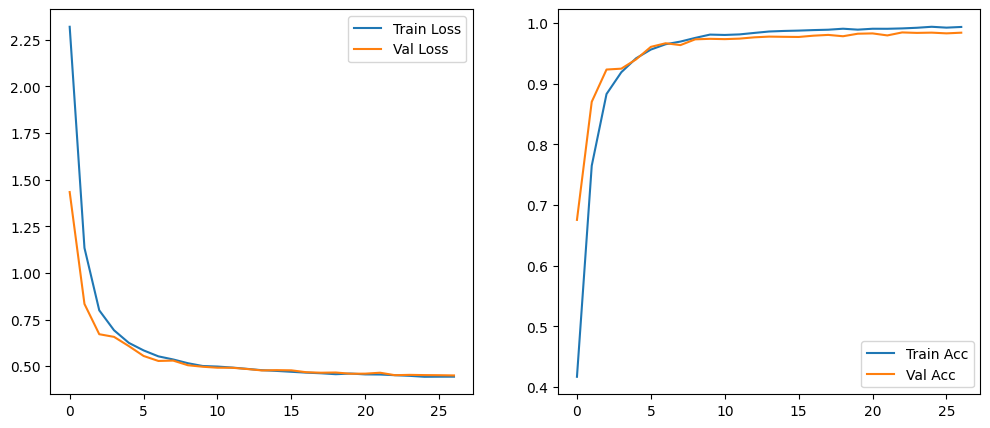

In [13]:
plot_training_curves(history)


In [14]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion, phase="test")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Evaluating test: 100%|██████████| 25/25 [00:59<00:00,  2.38s/it]

Test Loss: 0.7307, Test Accuracy: 0.8947
